In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path

# Tackling the SketchRNN Dataset
Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets

In [3]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 171s 0us/step


In [8]:
quickdraw_dir = Path(filepath).parent
quickdraw_dir

WindowsPath('C:/Users/alant/.keras/datasets/quickdraw')

In [9]:
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [14]:
train_files[:2], eval_files[:2], len(train_files), len(eval_files)

(['C:\\Users\\alant\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
  'C:\\Users\\alant\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010'],
 ['C:\\Users\\alant\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
  'C:\\Users\\alant\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010'],
 10,
 10)

In [16]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [21]:
assert train_classes == test_classes
len(train_classes), len(test_classes)

(345, 345)

> 345 classes of sketches

In [22]:
train_classes[:5]

['garden hose\n', 'lighter\n', 'penguin\n', 'tractor\n', 'sheep\n']

In [23]:
class_names = [name.strip() for name in train_classes]
class_names[:5]

['garden hose', 'lighter', 'penguin', 'tractor', 'sheep']

In [26]:
def parse(data_batch) :
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }   
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [27]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [37]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5]) # don't want to shuffl --> to plot images
test_set = quickdraw_dataset(eval_files[5:])

In [48]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.05882353  0.02500001  0.        ]
  [-0.6745098   0.07000002  0.        ]
  [-0.10980392  0.03499997  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.         -0.06274509  0.        ]
  [ 0.03773585 -0.12156862  0.        ]
  [ 0.         -0.5098039   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.024       0.06976742  0.        ]
  [-0.02        0.15503877  0.        ]
  [ 0.          0.17054266  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.02450979  0.4862745   1.        ]
  [ 0.02450979 -0.48235294  0.        ]
  [ 0.04411766 -0.02352941  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

> first batch (32 images) of training set

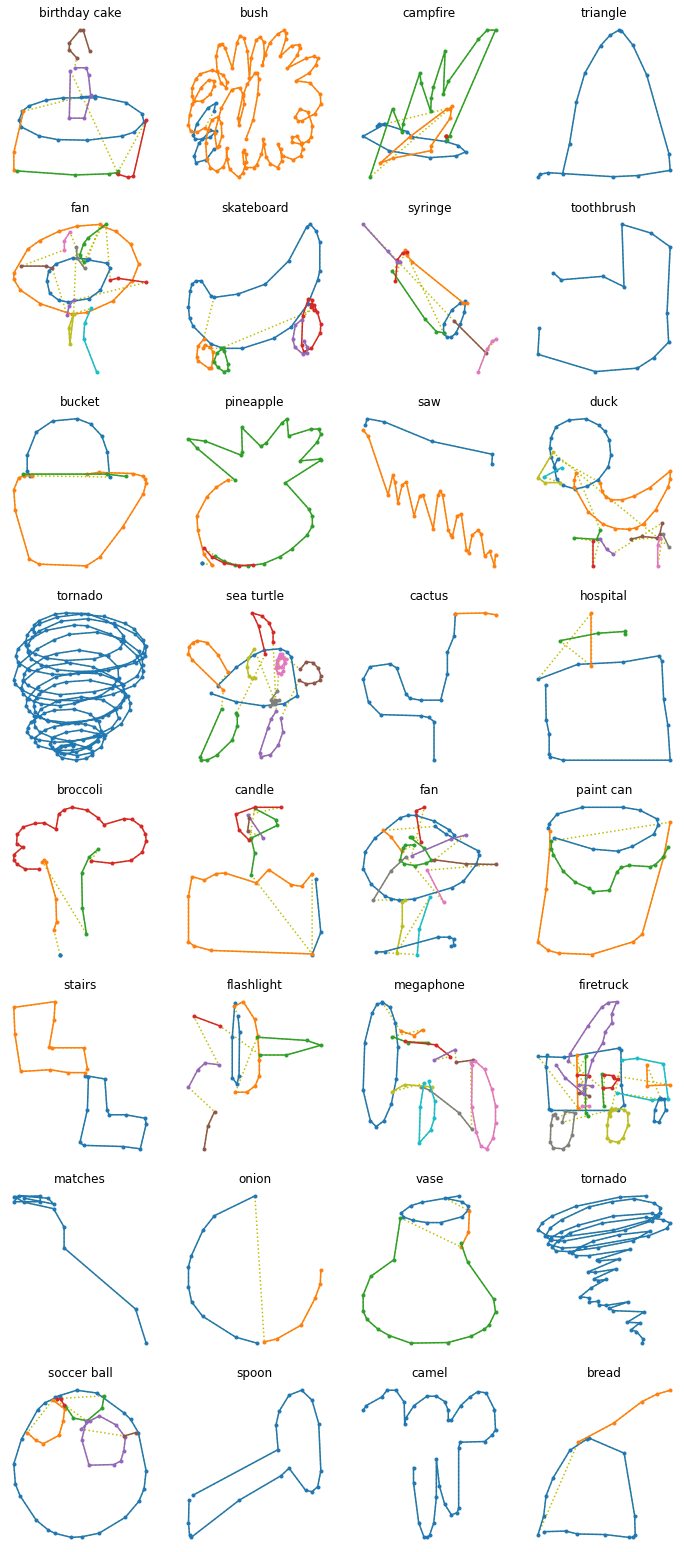

In [40]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

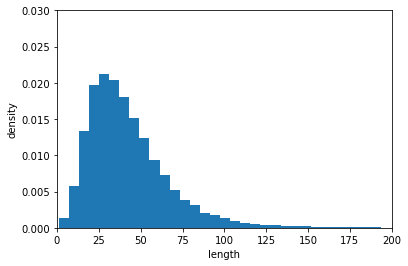

In [44]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

> Most sketches are composed of less than 100 points:

In [45]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [53]:
for sketches, labels in cropped_train_set.take(1):
    print("sketches =", sketches.shape)
    print("labels =", labels.shape)

sketches = (32, 100, 3)
labels = (32,)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,steps_per_epoch=107813,
                    validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

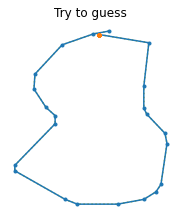

Top-5 predictions:
  1. spoon 1.788%
  2. boomerang 1.783%
  3. circle 1.597%
  4. paper clip 1.588%
  5. squiggle 1.395%
Answer: pear


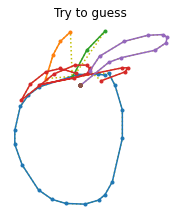

Top-5 predictions:
  1. motorbike 0.895%
  2. snowman 0.847%
  3. tractor 0.842%
  4. sea turtle 0.807%
  5. scorpion 0.793%
Answer: pineapple


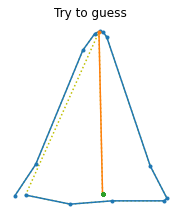

Top-5 predictions:
  1. ladder 1.930%
  2. line 1.785%
  3. bench 1.587%
  4. tent 1.554%
  5. swing set 1.523%
Answer: tent


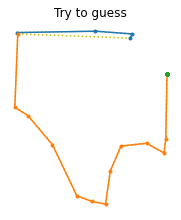

Top-5 predictions:
  1. line 3.545%
  2. stairs 2.168%
  3. triangle 2.166%
  4. square 2.105%
  5. zigzag 1.941%
Answer: underwear


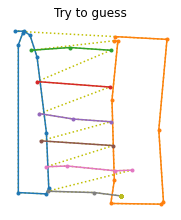

Top-5 predictions:
  1. spreadsheet 1.415%
  2. jail 1.348%
  3. bridge 1.278%
  4. barn 1.137%
  5. piano 1.135%
Answer: ladder


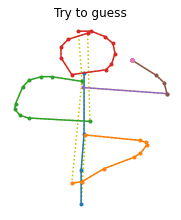

Top-5 predictions:
  1. washing machine 0.907%
  2. clock 0.854%
  3. baseball 0.845%
  4. hot air balloon 0.845%
  5. van 0.842%
Answer: yoga


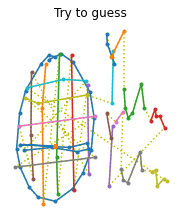

Top-5 predictions:
  1. hedgehog 0.941%
  2. stove 0.915%
  3. tiger 0.889%
  4. calendar 0.877%
  5. owl 0.873%
Answer: steak


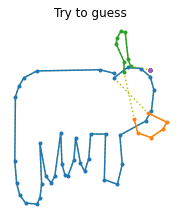

Top-5 predictions:
  1. butterfly 1.419%
  2. snowman 1.382%
  3. broccoli 1.327%
  4. rollerskates 1.122%
  5. flower 1.120%
Answer: cow


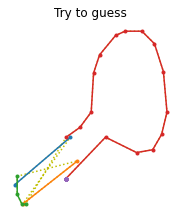

Top-5 predictions:
  1. spoon 1.535%
  2. boomerang 1.516%
  3. paper clip 1.416%
  4. circle 1.373%
  5. crown 1.260%
Answer: spoon


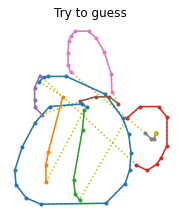

Top-5 predictions:
  1. cat 1.068%
  2. ant 1.050%
  3. bicycle 0.971%
  4. sea turtle 0.965%
  5. spider 0.949%
Answer: bee


In [64]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))